# Retiredge ETF Portfolio Optimization Implementation

I want to begin by acknowledging the sources that helped make this document and implementation possible.

**Resources**:
- **[Sample Code]** Efficient Frontier Portfolio Optimisation in Python (https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f)
- **[Sample Code]** ML time series forecasting the right way (https://towardsdatascience.com/ml-time-series-forecasting-the-right-way-cbf3678845ff)
- **[Sample Data]** Quandl ETF Data Bundle Product Overview (https://www.quandl.com/databases/ETFG/documentation)
- **[Documentation]** Exponential Smoothing (https://thequackdaddy.github.io/statsmodels.github.io/0.9.0/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html) 
- **[Theory]** Beating the ETF: Portfolio Optimisation using Python (…and some linear algebra) (https://towardsdatascience.com/beating-the-etf-portfolio-optimisation-using-python-and-some-linear-algebra-e48d0e0e44f)
- **[Theory]** PyPortfolioOpt Repo (https://github.com/robertmartin8/PyPortfolioOpt)

## Efficient Frontier and Modern Portfolio Theory

Modern Portfolio Theory (MPT) is an investment and finance theory developed by Harry Markowitz in 1952. In this code demo, Retiredge focuses on two of the underlying concepts: **risk-return trade-off** and **diversification**.

The goal for this implementation is to predict the best decision our user could make for their portfolio. This means we are not solely considering maximum possible returns and betting all on that one particular ETF. For every financial decision, there is an associated risk with a pattern that can be analyzed and predicted (for example thorugh volatility). Typically, higher risk is associated with a greater chance of a higher return (and lower risk - greater chance for lower return). Thus, for a risk-averse investor, a low risk portfolio is more preferable than a high risk one with the same expected returns. 

Efficient Frontier, which is an idea based on the MPT, aligns with this general investing attitude and emphasises that increasing risk is only worth a **compounded** chance at greater returns. The Efficient Frontier is essentially a line - tracing what the algorithm believes to be the 'smartest' randomly generated portfolios. This will be touched upon further down this document.

Sample ETF Net Asset Value (nav) data retrieved from Quandl will be used for analysis. Quandl is a platform which offers real time and historical data in a variety of financial fields. It also provides a python library for when importing directly through their database.


Diversifiction is another method of reducing portfolio risk, aside from analysing data of individual funds. By investing in multiple stocks, the chances of an overall loss is lower. A diverse, but not randomly chosen portfolio can help build the safety-net for non-aggressive investors and typically less experienced investors such as our target market of college students.

## Main Process and Functionalities

1. Importing Data and Lbraries
2. Preprocessing 
    1. Initial Visualizations
    2. ML Data Generation
3. Generating Random Portfolio
    1. Feature Visualization
    2. Maximum Sharpe Ratio
    3. Minimum Volatility
4. Calculating Efficient Frontier 
5. Display optimized portfolio
    1. Visualizations

## Importing Data and Libraries

The data imported below is the free sample Fund Flows data from Quandl's ETF Bundle. It is a small selection of the bundle itself, which has daily-updated information on 2,500+ US ETFs. This notebook analysis simply aims to show a snippet of what could be done with this information. 

In [3]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Use the two commands below if data should be directly imported from quandl
# ! pip install quandl # For installing onto this notebook only
# import quandl

import scipy.optimize as sco

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Below is code for importing data from quandl directly

# quandl.ApiConfig.api_key = '------------------'
# stocks = ['ETFG/ANLT']
# data = quandl.get_table('WIKI/PRICES', ticker = stocks,
#                         qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
#                         date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
# data.head()

# Importing Locally
df = pd.read_csv('ETFG_FUND.csv')
df

,date,ticker,shares_outstanding,nav,flow_daily,as_of_date
0,2018-01-03,EEM,837900000.0,48.12,0.0,2018-01-03
1,2018-01-04,EEM,837900000.0,48.45,0.0,2018-01-04
2,2018-01-05,EEM,845100000.0,48.80,348840000.0,2018-01-05
3,2018-01-08,EEM,855000000.0,49.03,483120000.0,2018-01-08
4,2018-01-09,EEM,855000000.0,48.96,0.0,2018-01-09
...,...,...,...,...,...,...
142,2018-01-29,TLT,57000000.0,122.75,98704000.0,2018-01-29
143,2018-01-30,TLT,57400000.0,121.97,49100000.0,2018-01-30
144,2018-01-31,TLT,54900000.0,122.77,-304925000.0,2018-01-31
145,2018-01-02,TLT,58400000.0,126.94,291157000.0,2017-12-29


By looking at the info() of data, it seems like the "date" column is already in datetime format.

In [5]:
# Use the two commands below to retrieve more information on the data
#df.info()
df.head() # To retrieve the first 5 items

,date,ticker,shares_outstanding,nav,flow_daily,as_of_date
0,2018-01-03,EEM,837900000.0,48.12,0.0,2018-01-03
1,2018-01-04,EEM,837900000.0,48.45,0.0,2018-01-04
2,2018-01-05,EEM,845100000.0,48.80,348840000.0,2018-01-05
3,2018-01-08,EEM,855000000.0,49.03,483120000.0,2018-01-08
4,2018-01-09,EEM,855000000.0,48.96,0.0,2018-01-09


## Preprocessing

In [6]:
# select only nav - Net Asset Value
df_mod = df[['date', 'ticker', 'nav']]
df_mod = df_mod.set_index('date')

Seven different ETFs are being compared in this analysis. They are:
- iShares MSCI Emerging Markets (EEM)
- SPDR S&P 500 (SPY)
- iShares MSCI EAFE (EFA)
- iShares Barclays 20+ Year Treasury Bond (TLT)
- SPDR Barclays Capital High Yield Bond (JNK)
- SPDR Gold Shares (GLD)
- iShares Russell 2000 (IWM)

In [7]:
# Ordering the data by the Funds
table = df_mod.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,EEM,EFA,GLD,IWM,JNK,SPY,TLT
date,,,,,,,
2018-01-02,47.07,70.49,124.5286,152.44,36.6357,266.552,126.94
2018-01-03,48.12,70.75,124.7978,154.14,36.7982,270.489,126.05
2018-01-04,48.45,71.80,124.7585,154.46,36.9077,271.635,126.04
2018-01-05,48.80,72.21,125.0087,154.89,36.9601,273.541,125.51
2018-01-08,49.03,72.14,125.2703,155.07,36.9548,273.999,125.46


### Initial Visualizations

Text(0, 0.5, 'Net Asset Value in $')

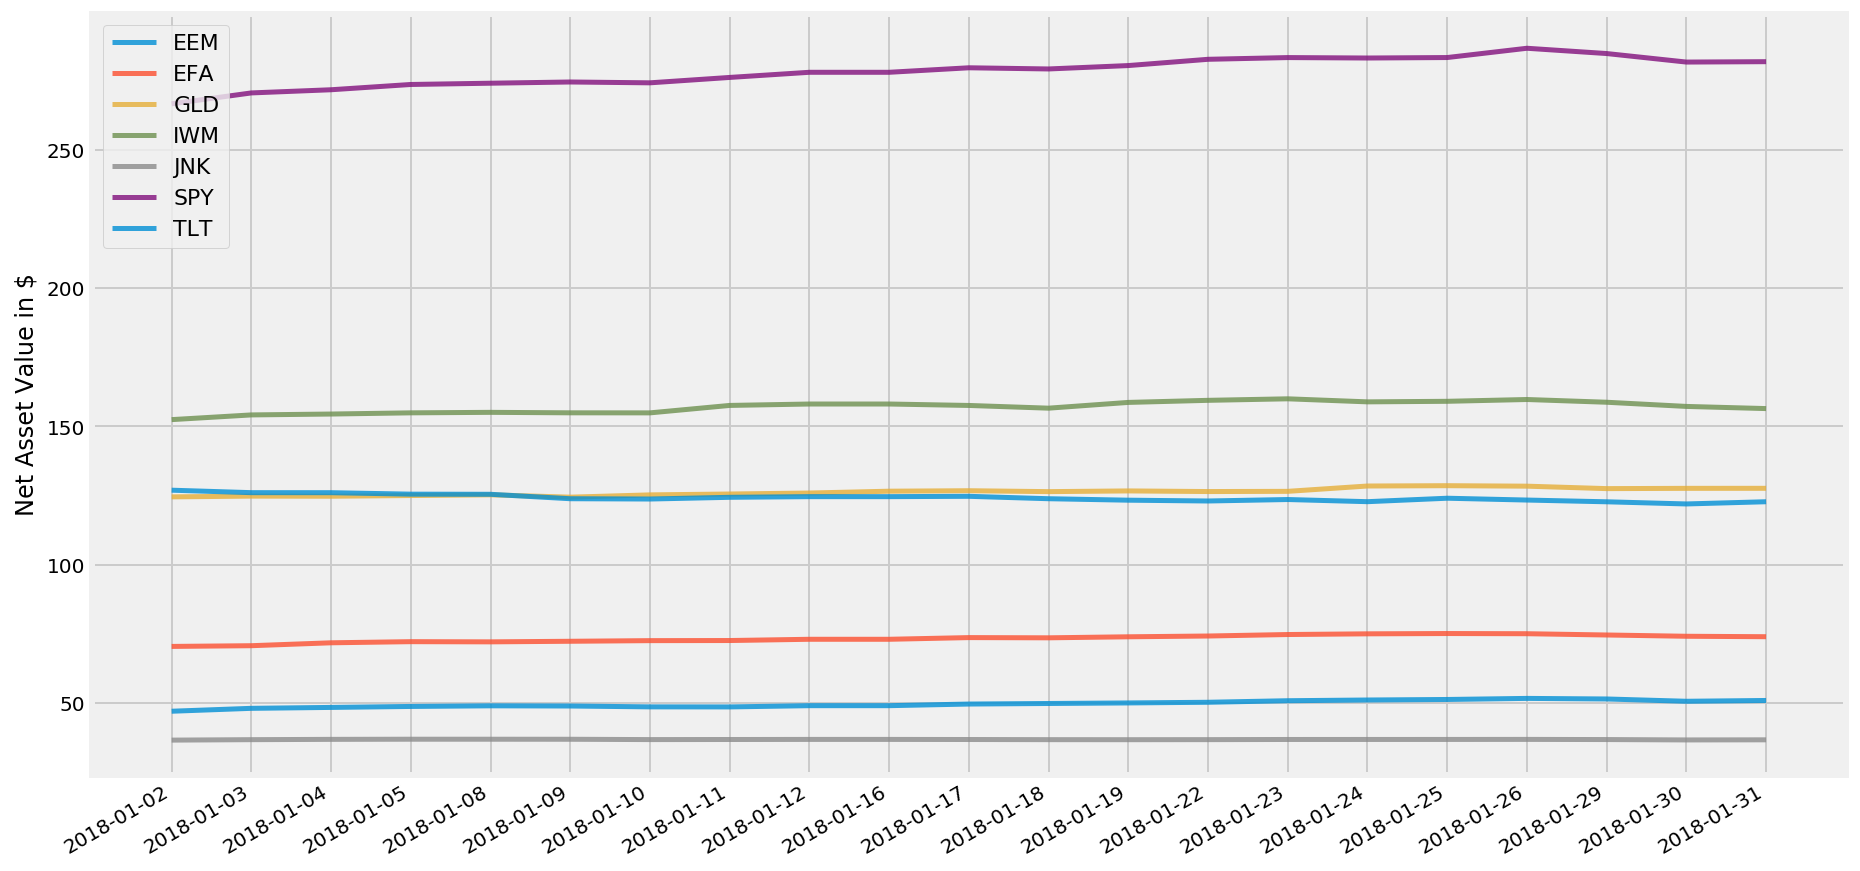

In [8]:
# Plotting the sample data
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=2.5, alpha=0.8,label=c)
    
locs, labels = plt.xticks() 
plt.setp(labels, rotation=30, horizontalalignment='right')
plt.legend(loc='upper left', fontsize=11)
plt.ylabel('Net Asset Value in $')

It looks like SPY is consistently at a higher value than the other ETFs.

The below cell plotts daily changes (percent change compared to the day before) in nav, showing the funds' volatility.

Text(0, 0.5, 'daily returns')

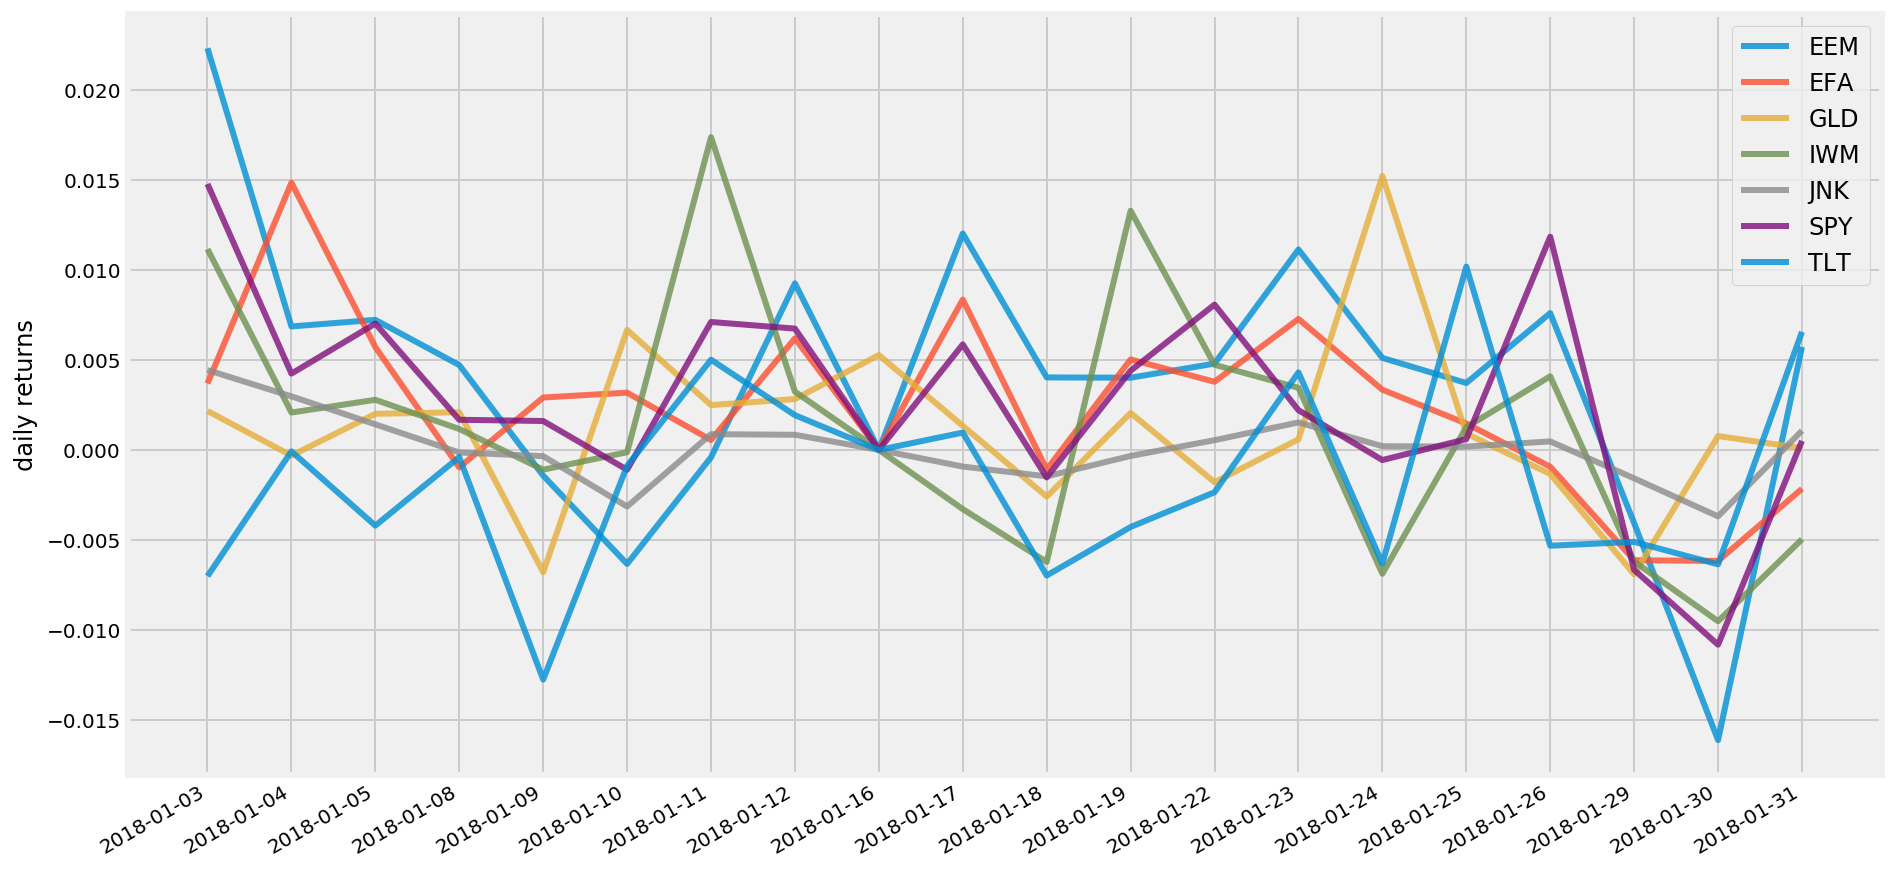

In [9]:
returns = table.pct_change()

plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
locs, labels = plt.xticks() 
plt.setp(labels, rotation=30, horizontalalignment='right')
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

It seems EEM (Top Blue line at the left hand side) is slightly more volatile than the other ETFs. And TLT (bottom blue line) tends to perfrom worse than other ETFs. The least volatile is JNK.

### Generating Future Values

For the sake of this class, we decided to use the free sample data. Quandl's many more complete and in-depth datasets are available for purchase for $3000 a year, which has been taken into consideration in our slidedeck and pitch. 

However, to better illustrate our technology with a realistic dataset, machine learning, specifically time series forcasting will be performed below to increase the size of our data beyond one month. This same technology can be used for additional portfolio prediction research to complement this efficient frontier implementation.

In [10]:
# Getting the Model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

def getmodelfit(y):
    model = ExponentialSmoothing(y, 
                             trend = 'multiplicative',
                             seasonal = 'multiplicative',
                             seasonal_periods = 6)
    fit = model.fit(smoothing_level = 0.05, smoothing_slope = 0.05, smoothing_seasonal = 0.05)
    return model, fit

In [11]:
# Creating lag features which helps in utilizing supervized learning
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import pacf

def create_lag_features(y):
   
    scaler = StandardScaler()
    features = pd.DataFrame()
    
    partial = pd.Series(data=pacf(y, nlags=2)) # you can change value of nlags to be smaller - every 2 days
    lags = list(partial[np.abs(partial) >= 0.2].index)
    
    df = pd.DataFrame()
    
    # avoid to insert the time series itself
    lags.remove(0)
    
    for l in lags:
        df[f"lag_{l}"] = y.shift(l)
    
    features = pd.DataFrame(scaler.fit_transform(df[df.columns]),
                            columns=df.columns)
    features.index = y.index
    
    return features

In [12]:
# Make a prediction using the fit and plot the prediction and original
def makepred(name, orig, fit, n):
    pred = fit.forecast(n)
    plt.plot(pred, label = name)
    plt.plot(orig)
    plt.xticks([table.index[0], table.index[-1]], visible=True, rotation=90)
    plt.legend();
    return pred

The following function: *recursive_forecast* is another implementation of makepred, however, it has more potential for implementing a greater degree of ML supervised learning processes to make future time series predictions. The default number for *n_steps* can be changed to reflect how long of a prediction one would want to make. Here we are predicting 300 days into the future.

In [13]:
# Make a prediction and plot the original and prediction. Adds date values to predictiona and 
# returns a Series of the prediction
def recursive_forecast(name, y, fit, lags, 
                       n_steps=300, step="D"):
    
    """
    Parameters
    ----------
    y: pd.Series holding the input time-series to forecast
    model: pre-trained machine learning model
    lags: list of lags used for training the model
    n_steps: number of time periods in the forecasting horizon
    step: forecasting time period
    
    Returns
    -------
    fcast_values: pd.Series with forecasted values 
    """
    
    # get the dates to forecast
    last_date = '2018-02-01'
    fcast_range = pd.date_range(last_date, 
                                periods=n_steps, 
                                freq=step)
    fcasted_values = []
    target = y.copy()
    i = 0
        
    pred = fit.forecast(n_steps)
    
    #plot for viewing
    plt.plot(pred, label = name)
    plt.plot(y)
    plt.xticks([table.index[0], table.index[-1]], visible=True, rotation="horizontal")
    plt.legend();
    
    for date in fcast_range:
      
        # build target time series using previously forecast value
        new_point = fcasted_values[-1] if len(fcasted_values) > 0 else 0.0   
        target = target.append(pd.Series(index=[date], data=new_point))
    
        # The Code below can be modified to caculate real features for supervised learning  
#         # build feature vector using previous forecast values
#         features = create_ts_features(target, lags=lags)
        
#         # forecast
#         predictions = model.predict(features)
        fcasted_values.append(pred.iloc[i])
        i += 1
        
    return pd.Series(index=fcast_range, data=fcasted_values)


Below is the execution. The red info/warning messages can be ignored, as they do not intefer with the algorithm and visualizations.

In [14]:
# The list of ETFs we are tracking.
etfs = ['EEM', 'EFA', 'GLD', 'IWM', 'JNK', 'SPY','TLT']

/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index begin

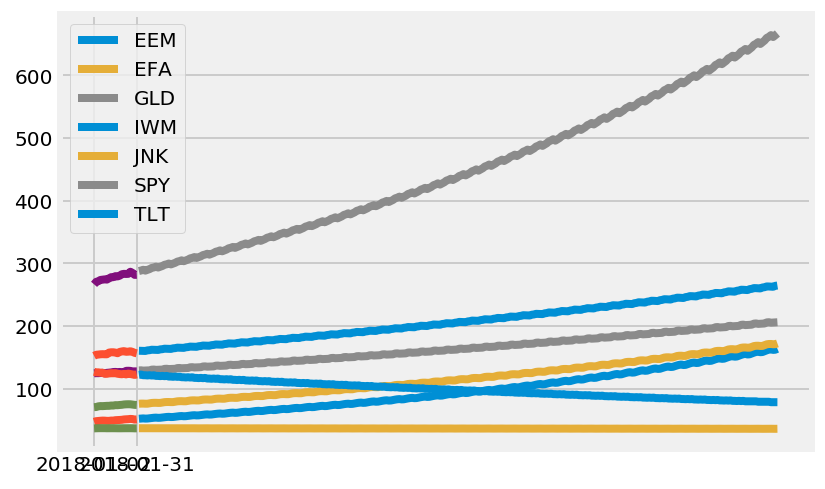

In [17]:
mfps = {}
#index = pd.date_range('2018-02-01', periods=120, freq='D')

for s in etfs:
    y = table[s]
    lag = create_lag_features(y)
    model, fit = getmodelfit(y)
    #pred = makepred(s, y, fit, 48)
    pred = recursive_forecast(s, y, fit, lag)
    mfps[s] = [model, lag, fit, pred]

The predicted trajectory follows the paths our data has taken in January 2018. Realistically, of course, the data would would be much more volatile with a lot of noise. However, the Efficient Frontier method is effective even when the data trends seem monotone, and the following code would not need to be modified to be applied to other highly different real world data.

In [18]:
# mfps['EEM'][3].to_frame().rename({0:})
id = pd.date_range('2018-02-01', periods=300, freq='D')
columns = etfs
df_f = pd.DataFrame(index=id, columns=columns)
for s in etfs:
    df_f[s] = mfps[s][3]
df_f.head()

df_p = pd.concat([table, df_f])
df_p

,EEM,EFA,GLD,IWM,JNK,SPY,TLT
2018-01-02,47.070000,70.490000,124.528600,152.440000,36.635700,266.552000,126.940000
2018-01-03,48.120000,70.750000,124.797800,154.140000,36.798200,270.489000,126.050000
2018-01-04,48.450000,71.800000,124.758500,154.460000,36.907700,271.635000,126.040000
2018-01-05,48.800000,72.210000,125.008700,154.890000,36.960100,273.541000,125.510000
2018-01-08,49.030000,72.140000,125.270300,155.070000,36.954800,273.999000,125.460000
...,...,...,...,...,...,...,...
2018-11-23 00:00:00,162.256400,171.286724,206.072306,263.089381,36.031412,661.645364,79.089855
2018-11-24 00:00:00,162.829005,171.326604,205.341395,262.813101,36.015387,664.345810,78.426219
2018-11-25 00:00:00,161.894321,170.948506,205.614502,262.632118,35.901892,661.271681,78.388672
2018-11-26 00:00:00,162.199485,171.006309,205.798565,264.117150,35.920285,664.169494,78.177747


## Random Portfolios Generation

There are 7 funds in this portfolio. One decision the user could make is how to allocate their budget to each of ETFs (i.e. diversification). The below functions help with generating random weights to each fund, then calcualte and return the annualized return and volatility for comparision.

These functions were modified adapted from Ricky Kim's sample code (the first linked source).

In [19]:
# Calculate the returns and volatility. The number 365 can change depending on the number of trading days per year.
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns *weights ) *365
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [20]:
# Generate portfolios with random weight allocation. Returns the results and the weights. 
# The number generated can be modified
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(7) # modify number to be number of etfs being analyzed
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

The below terminology commonly refers to general stock indexes, but can be applied to the net asset value of ETFs as well.
Daily change or returns can be found by calling pct_change on the dataframe. The below also sets the mean returns, covariance matrix, number of random portfolios generated, and the risk free rate.

In [52]:
returns = df_p.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [46]:
mean_returns

EEM    0.003915
EFA    0.002804
GLD    0.001581
IWM    0.001731
JNK   -0.000055
SPY    0.002877
TLT   -0.001495
dtype: float64

### Visualization and Output of Random Portfolios

The visualization below plots all randomly generated portfolios, the bluer the color, the higher its Sharpe ratio. The red star is the portfolio with the highest sharpe ratio, while the green star (the lower left star) is the portfolio with the lowest volatility. The specific weight/budget allocation for these two portfolios will also be displayed.

The Sharpe Ratio is a metric which calculates the return on investment compared to its risk, offering additonal insight into portfolio gains. 

In [47]:
# Generates random portfolios and gets results and corresponding weights. Then locates the highest Sharpe ratio
# portfolio as well as the minimum volatilit portfolio. Then all the portfolios are plotted on the graph below.
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.06
Annualised Volatility: 0.06


              EEM   EFA   GLD    IWM   JNK   SPY   TLT
allocation  32.78  11.2  9.98  13.16  0.21  32.1  0.58
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.13
Annualised Volatility: 0.03


             EEM   EFA   GLD    IWM    JNK   SPY    TLT
allocation  1.11  5.05  9.69  10.23  55.86  3.04  15.02


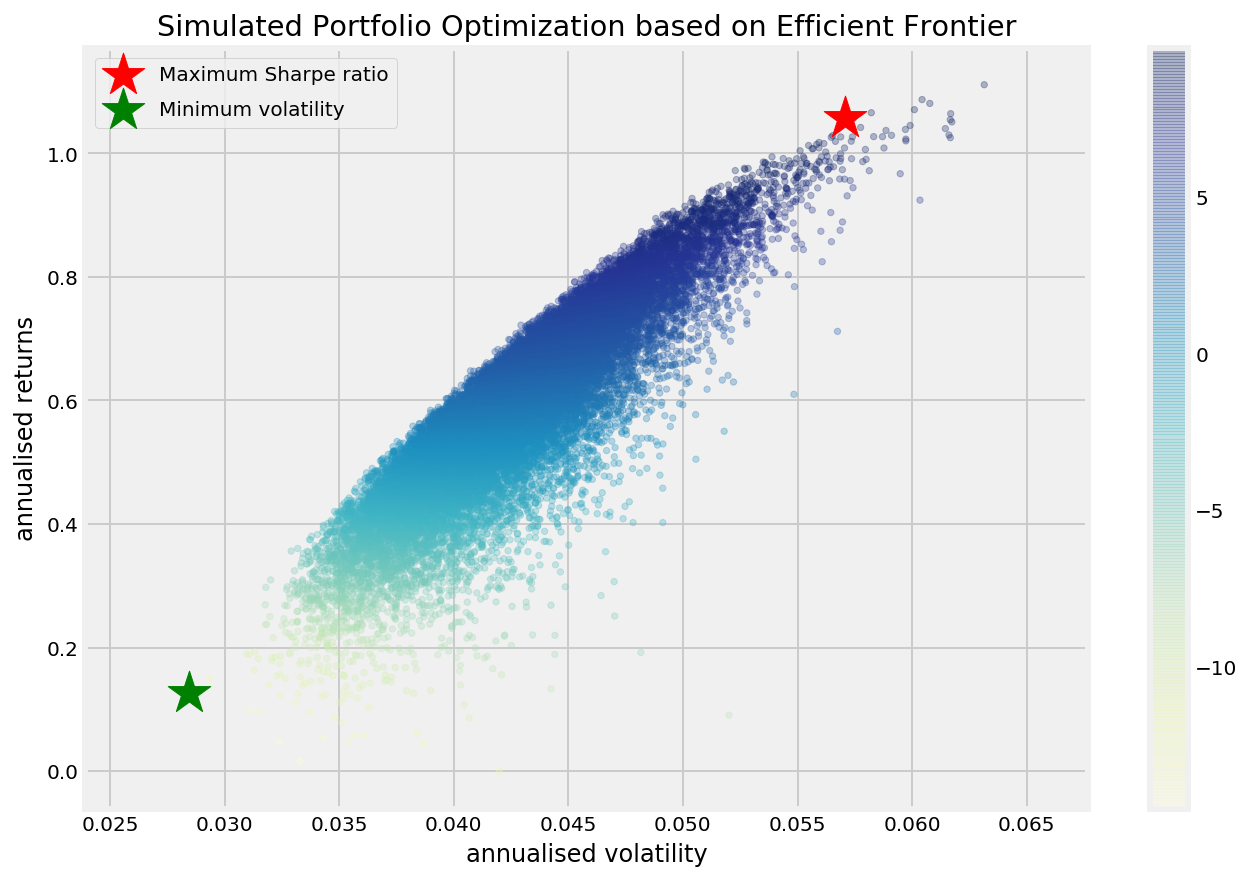

In [48]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

For minimum risk portfolio, we can see that over half of our budget is allocated to JNK. This can be identified as the least volatile ETF from the daily returns visualization. 

However for a higher return, at the cost of a higher risk, our budget is much more evenly allocated, with JNK and TLT having close to 0 weights. This parallels the mean_returns calculated earlier. The least volatile often offer much less in returns than the most volatile.

## Efficient Frontier

From the above visualization, an arch line can be identified at the top left edge of the dot cluster. The efficient frontier is precisely this line. It identifies the points (portfolios) that given a target return has the lowest risk. Because points along the line will give you the lowest risk for a given target return. Thus all of these points are the most efficient portfolio choices.

The below functions utlizes Scipy's optimize function to get the maximum Sharpe ratio portfolio. This is a more accurate than the previous method of generating randomized portfolios. The "neg_sharpe_ratio" computes the negative Sharpe ratio, due to Scipy only having a minimzation option. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated. 

In [39]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

# Calculates maximum sharpe ration portfolio using Scipy. Defining arguments and construncting constraints for minimization.
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # all the weights must sum to 1
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets)) # any weight should be inclusively between 0 and 1
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

Similarly, Scipy can be used for a more accurate calculation of volatility. 

In [40]:
# Calculating volatility of a portfolio
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

# Returning the minimum variance, i.e. least volatile portfolio result.
def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # same constraints
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

The code below computes the efficient frontier line in increments of return changes. 

In [41]:
# Calculates the efficient return: minimum volatility for a target return
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Finds the efficient frontier for a range of return targets
def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

### Efficient Frontier Visualization

Now we plot the efficient frontier, then display maximum Sharpe ratio and minimum volatility with all the previously randomly generated portfolios. Note this is different to the previously found two optimal portfolio, which were simply selected from the random generations. 

In [57]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 1, 50) # the length of the line can be modified
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.02
Annualised Volatility: 0.05


              EEM  EFA    GLD    IWM  JNK    SPY  TLT
allocation  32.54  0.0  23.47  10.66  0.0  33.33  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.04
Annualised Volatility: 0.02


            EEM  EFA   GLD  IWM    JNK  SPY   TLT
allocation  0.0  0.0  4.91  0.0  85.55  0.0  9.54


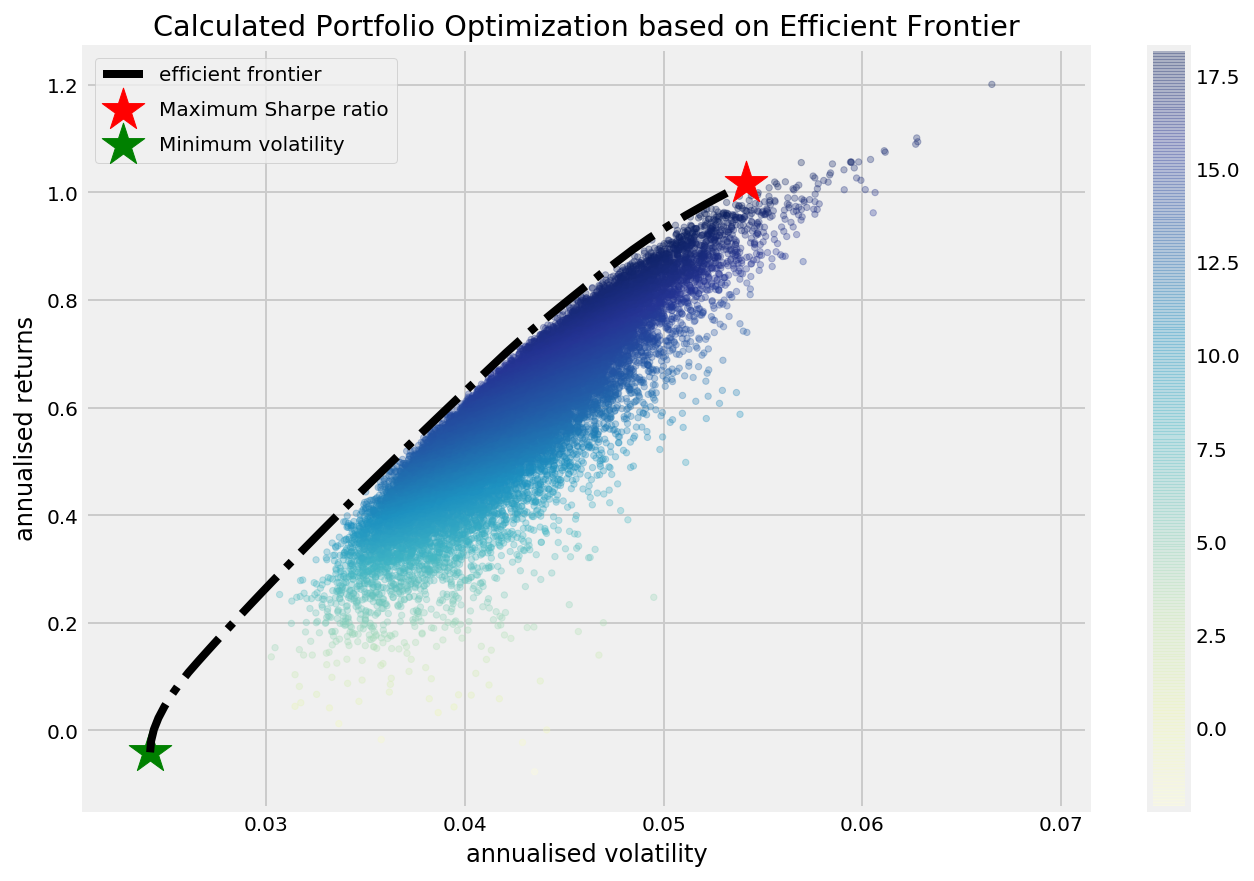

In [58]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

The calculated Scipy's minimum volatility has allocated most (over 85%) of the budget to JNK despite a below 0 annualized return. Evidently the least volatile also tends to yield the least returns, and a smart invester would not chose to 100% risk averse. For the maximum Sharpe ratio portfolio calculated through Scipy, we can see it yields a higher return than found through randomized generation. There is a less even distribution across the ETFs, with EEM and SPY covering a combined 2/3 of the budget allocation. Refering back to the visualization of our generated data, we can identify those two funds as the fastest growing funds. 

### Final Portfolio Decisions Output

Removing the irrelevant information for our users, the randomly generated portfolios, we can finally display the efficient frontier line with two extreme portfolio options along with the risk and returns of each individual fund. This can help accurately illustrate the effects diversification and risk-minization have on the overall portfolio's perfomance. The user can also utilize this information to better make informed decisions for how they wish to construct their portfolio.

In [62]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print( "-"*80)
    print( "Maximum Sharpe Ratio Portfolio Allocation\n")
    print( "Annualised Return:", round(rp,2))
    print( "Annualised Volatility:", round(sdp,2))
    print( "\n")
    print( max_sharpe_allocation)
    print( "-"*80)
    print( "Minimum Volatility Portfolio Allocation\n")
    print( "Annualised Return:", round(rp_min,2))
    print( "Annualised Volatility:", round(sdp_min,2))
    print( "\n")
    print( min_vol_allocation)
    print( "-"*80)
    print( "Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print( txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print( "-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 1, 50) # the length of the line can be modified
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.02
Annualised Volatility: 0.05


              EEM  EFA    GLD    IWM  JNK    SPY  TLT
allocation  32.54  0.0  23.47  10.66  0.0  33.33  0.0
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: -0.04
Annualised Volatility: 0.02


            EEM  EFA   GLD  IWM    JNK  SPY   TLT
allocation  0.0  0.0  4.91  0.0  85.55  0.0  9.54
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

EEM : annuaised return 0.99 , annualised volatility: 0.08
EFA : annuaised return 0.71 , annualised volatility: 0.06
GLD : annuaised return 0.4 , annualised volatility: 0.06
IWM : annuaised return 0.44 , annualised volatility: 0.05
JNK : annuaised return -0.01 , annualised volatility: 0.03
SPY : annuaised return 0.

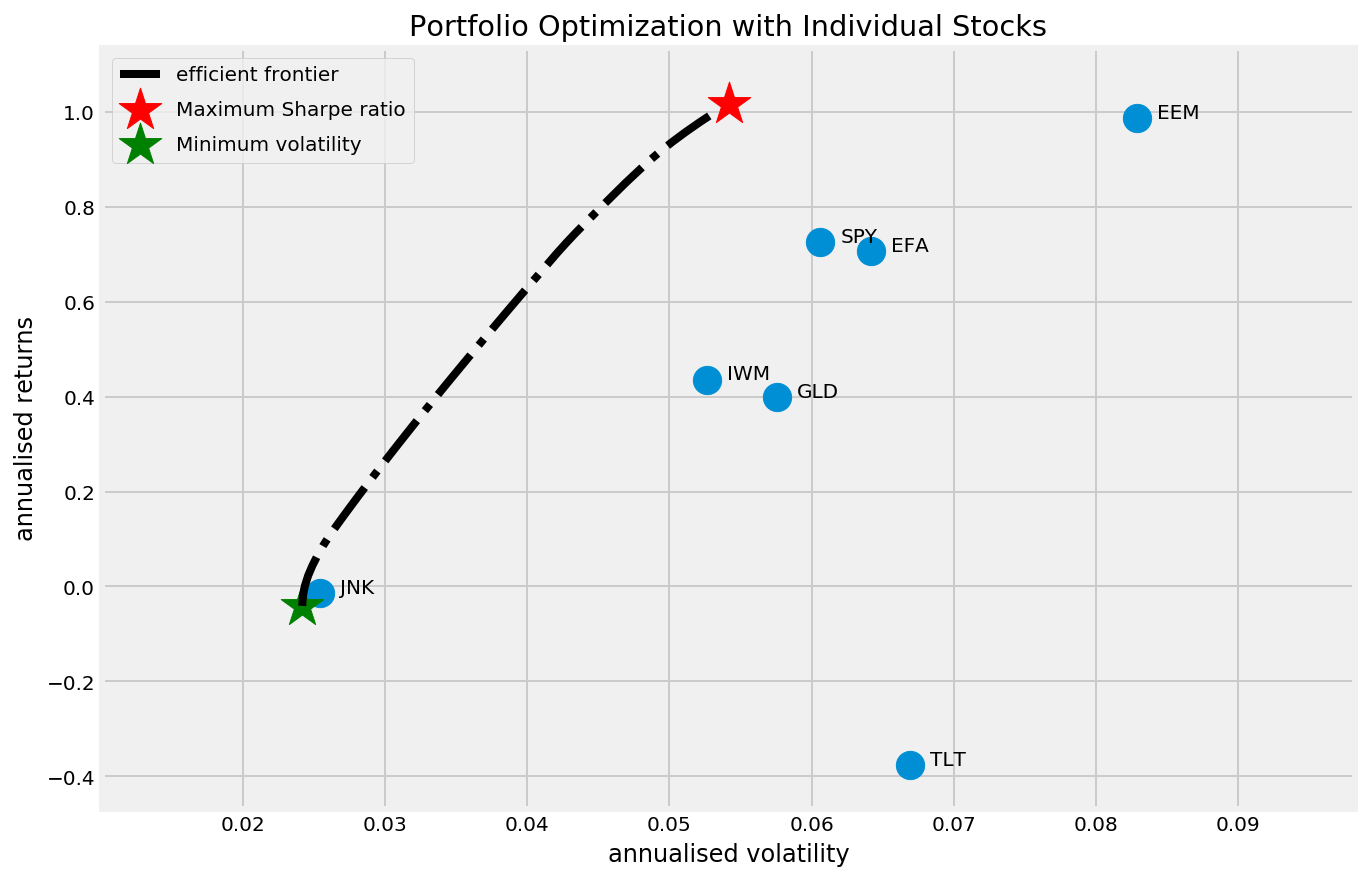

In [63]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

The Efficient Frontier can be seen tracing from the minimized volatility towards the maximum Sharpe Ratio. In implementation of our application, the sample portfolio as well as the graph outputted here can be displayed on our UI. Ultimately guiding our users to make more informed decisions for retirement investing. Some features through this particular implementation I want to highlight are the degree of flexibility in the technical methodologies. Variables such as, number of generated portfolios, risk rate the user wishes to tolerate, as well as specific functions for outputting the optimized portfolio allocations can all be modified. This is only one sliver of how this generalized function can become personalized for each individual user, providing a friendly and rewarding investing experiencelike no other.